# Gradient Boosted Tree Model with Light GBM
using sci-kit optimize and categorical data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from lightgbm import plot_tree
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
import graphviz

**Note:** Light GBM can't work with Polars

In [2]:
X = pd.read_csv("Data/training_set_features.csv", index_col="respondent_id")

In [3]:
X=X[:].astype("category")

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   h1n1_concern                 26615 non-null  category
 1   h1n1_knowledge               26591 non-null  category
 2   behavioral_antiviral_meds    26636 non-null  category
 3   behavioral_avoidance         26499 non-null  category
 4   behavioral_face_mask         26688 non-null  category
 5   behavioral_wash_hands        26665 non-null  category
 6   behavioral_large_gatherings  26620 non-null  category
 7   behavioral_outside_home      26625 non-null  category
 8   behavioral_touch_face        26579 non-null  category
 9   doctor_recc_h1n1             24547 non-null  category
 10  doctor_recc_seasonal         24547 non-null  category
 11  chronic_med_condition        25736 non-null  category
 12  child_under_6_months         25887 non-null  category
 13  health

In [5]:
y1 = pd.read_csv("Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "h1n1_vaccine"])
y2 = pd.read_csv("Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "seasonal_vaccine"])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42, stratify=y2)

y1: h1n1 labels

y2: seasonal labels

In [6]:
clf = LGBMClassifier(n_jobs=1,random_state=8) # n_jobs = 1 aka only one process in parallel (because the optimizer will run multiple models in parallel)


In [ ]:
'''estimators = [
    ('encoder', OrdinalEncoder()),
    #('clf', XGBClassifier(random_state=8, enable_categorical=True))
    ('clf', LGBMClassifier(n_jobs=1,random_state=8)) # n_jobs = 1 aka only one process in parallel (because the optimizer will run multiple models in parallel)
]
northstream = Pipeline(estimators)
northstream'''

Pipeline(steps=[('encoder', OrdinalEncoder()),
                ('clf', LGBMClassifier(n_jobs=1, random_state=8))])

In [14]:
# Hyperparameter tuning
search_space = {
    'max_depth': Integer(1, 6),
    'learning_rate': Real(0.001, 1.0, 'log-uniform'),
    'subsample': Real(0.1, 1.0),
    'subsample_freq': Integer(0, 10),
    'colsample_bytree': Real(0.1, 1.0),
    'min_child_weight': Real(0.001, 100, 'log-uniform'),
    'reg_alpha': Real(0.0, 10.0), # in LGBM; the value is not limited to [0 to 1]
    'reg_lambda': Real(0.0, 10.0), # in LGBM ; the value is not limited to [0 to 1]
    #'scale_pos_weight': Real(1.0, 500.0), #nicht benutzt da in der Dokumentation nicht empfohlen
}


In [15]:
opt = BayesSearchCV(
    clf,
    search_space,
    cv=5,
    n_iter=50,
    random_state=50,
    scoring='roc_auc',
    n_points=1, # no. of hyperparamters sets evaluated at the same time
    n_jobs=8, # no. of processes running in parallel
)


In [16]:
opt.fit(X_train1, y_train1)

c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 4539, number of negative: 16826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212450 -> initscore=-1.310219
[LightGBM] [Info] Start training from score -1.310219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

BayesSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=1, random_state=8),
              n_jobs=8, random_state=50, scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=6, prior='uniform', transform='...
                             'min_child_weight': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=10, prior='uniform', transform='normalize')})

In [17]:
print("Best fitting score: ", opt.best_score_)
print("Test score: ", opt.score(X_test1, y_test1))

Best fitting score:  0.8696887482805676
Test score:  0.8609540005172834


In [18]:
opt.predict(X_test1)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
opt.best_estimator_.booster_.save_model("LGBM_Cat_h1n1_vaccine.txt")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

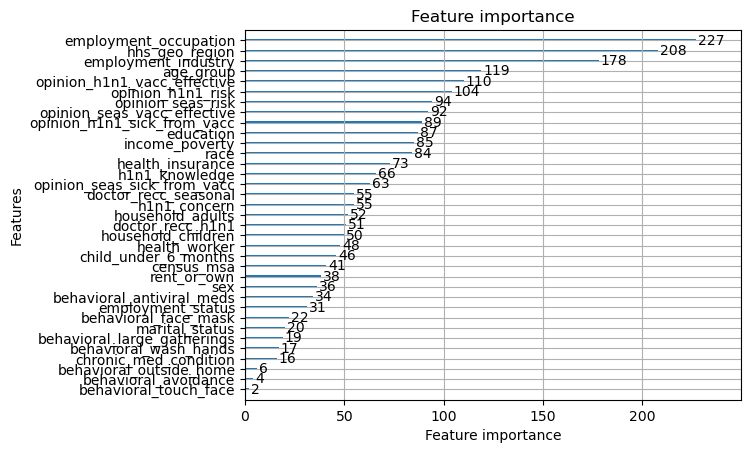

In [20]:
plot_importance(opt.best_estimator_)

<Axes: >

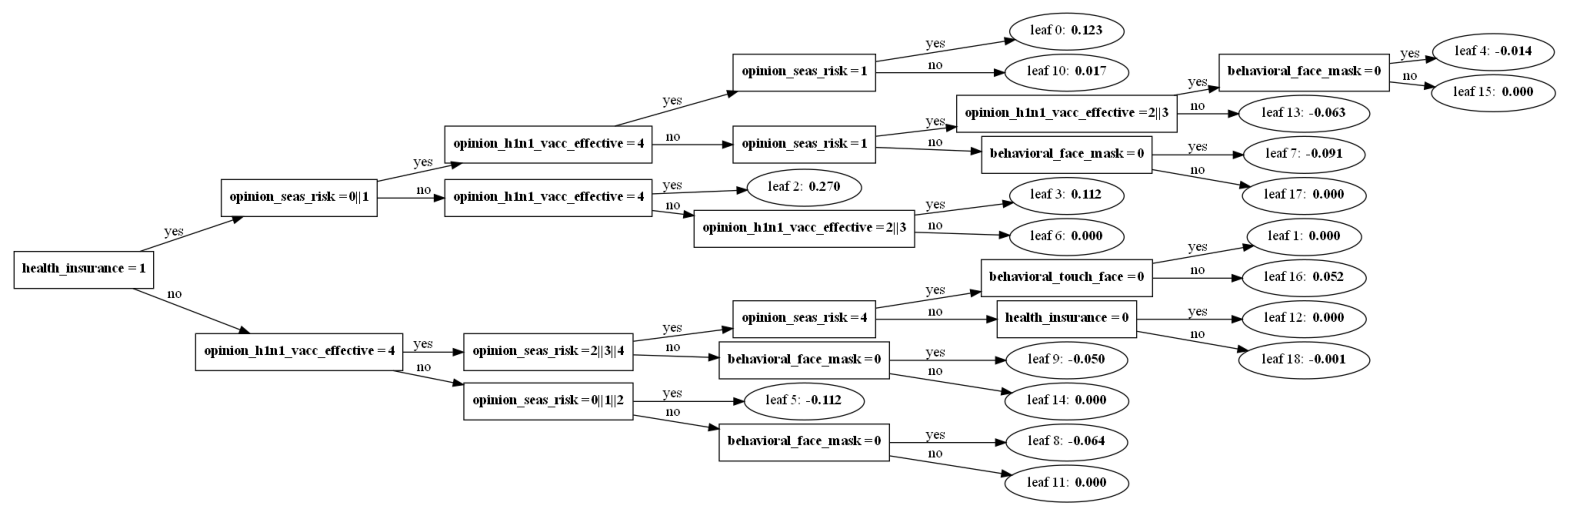

In [21]:
plot_tree(opt.best_estimator_, tree_index=2, figsize=(20, 10))

In [22]:
opt2 = BayesSearchCV(
    clf,
    search_space,
    cv=5,
    n_iter=50,
    random_state=50,
    scoring='roc_auc',
    n_points=1, # no. of hyperparamters sets evaluated at the same time
    n_jobs=-1, # no. of processes running in parallel
)

In [23]:
opt2.fit(X_train2, y_train2)

c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 9948, number of negative: 11417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465621 -> initscore=-0.137732
[LightGBM] [Info] Start training from score -0.137732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

BayesSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=1, random_state=8),
              n_jobs=-1, random_state=50, scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=6, prior='uniform', transform=...
                             'min_child_weight': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=10, prior='uniform', transform='normalize')})

In [24]:
print("Best fitting score: ", opt2.best_score_)
print("Test score: ", opt2.score(X_test2, y_test2))

Best fitting score:  0.8621564014447994
Test score:  0.8660303631422803


In [25]:
opt2.best_estimator_.booster_.save_model("LGBM_Cat_seas_vaccine.txt")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

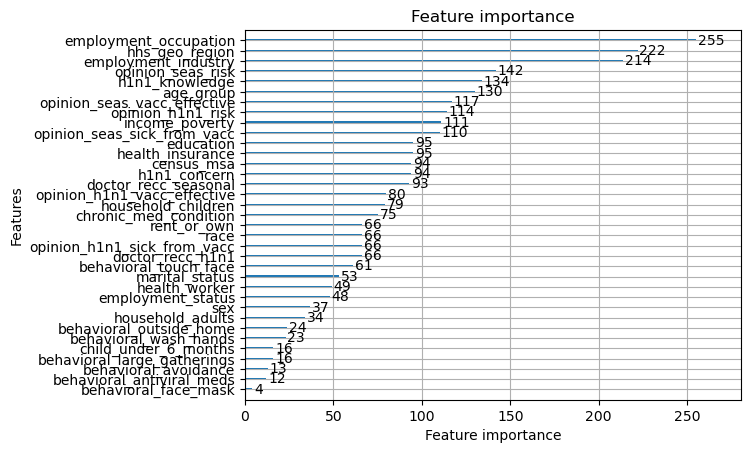

In [26]:
plot_importance(opt2.best_estimator_)

# Submission Data

In [29]:
df_test_set_features = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')
df_test_set_features=df_test_set_features[:].astype("category")

In [30]:
h1n1_vaccine_probability=opt.predict_proba(df_test_set_features)
seas_vaccine_probability=opt2.predict_proba(df_test_set_features)

df_submission = df_test_set_features[[]]
df_submission['h1n1_vaccine'] = h1n1_vaccine_probability[:,1].tolist()
df_submission['seasonal_vaccine'] = seas_vaccine_probability[:,1].tolist()

C:\Users\sager\AppData\Local\Temp\ipykernel_2108\332240964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['h1n1_vaccine'] = h1n1_vaccine_probability[:,1].tolist()
C:\Users\sager\AppData\Local\Temp\ipykernel_2108\332240964.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['seasonal_vaccine'] = seas_vaccine_probability[:,1].tolist()


In [31]:
df_submission.to_csv("LGBM_Model/Cat_submission.csv")